In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import numpy as np
from astropy.table import QTable
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
ravetable = QTable.read('NEW_rave_tgas_query.csv', format='csv')

In [31]:
print(ravetable)

row_id    ID_TGAS_source   ...          V                   W         
------ ------------------- ... ------------------- -------------------
     1 5472450241103924224 ... -0.9575534944991164  1.4669302037815846
     2 5472934404177638016 ...  23.492250983607107  11.099693023171763
     3 5472961651450144128 ... -3.9424078957028885  27.628285376067435
     4 5470860587808517120 ...  -41.41716768003139  -9.975578575429465
     5 3468060163078890752 ...   1.721921835508148    4.11190804267663
     6 6158339888161766400 ...   7.654037592058611    59.1600144573125
     7 6158610402382100096 ...   29.60669658206545  33.315725922614966
     8 6158160633407813888 ...   -21.6458825772679   79.37642833064345
     9 6123173658014875136 ...     26.111286649449 0.10343703483967381
    10 6123181698193650176 ...  10.961645644882031  -6.895792106539008
   ...                 ... ...                 ...                 ...
 39843 2961559926901589504 ...   78.27231238095658 -11.123773869368694
 39844

In [3]:
#Assigning columns in the data table to variable names

pmra = ravetable['pmRA_TGAS']
pmde = ravetable['pmDE_TGAS']
ra = ravetable['RA_TGAS']
dec = ravetable['DE_TGAS']
hrv = ravetable['HRV']
plx = ravetable['parallax_TGAS']
pm = np.sqrt(pmde**2 + (pmra**2) * np.cos(dec)**2)

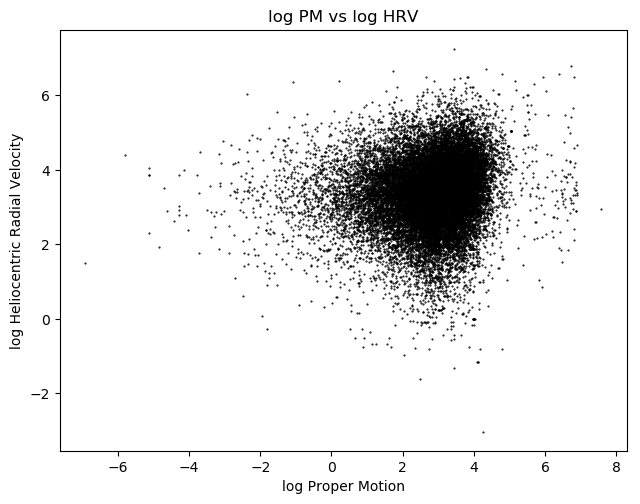

In [4]:
#Plotting data in velocity space

plt.style.use('default')
fig = plt.figure()
ax = fig.add_subplot(111)
 
fig.tight_layout()

ax.set_ylabel("log Heliocentric Radial Velocity")
ax.set_xlabel("log Proper Motion")
ax.set_title("log PM vs log HRV")
    
ax.plot(np.log(hrv), np.log(pm), color='k', marker='.', markersize=1, linestyle='None');

In [4]:
#Adjusting between arcseconds and milliarcseconds

pmra = pmra * 0.001
pmde = pmde * 0.001
plx = plx * 0.001

In [5]:
#Constants for progressing into galactocentric coordinates

rangp = np.radians(192.8583)
decngp = np.radians(27.1280559)
theta0 = np.radians(122.93191857)
k = 4.704057

In [6]:
#Establishing variables for progressing into galactocentric coordinates
#because I was having troubles with matrices and arrays.

a = np.cos(theta0)
b = np.sin(theta0)
c = np.sin(decngp)
d = np.cos(decngp)
e = np.cos(rangp)
f = np.sin(rangp)
g = np.cos(ra)*np.cos(dec)
h = np.sin(ra)
i = np.sin(ra)*np.cos(dec)
j = np.cos(ra)
z = np.sin(ra)*np.sin(dec)
l = np.sin(dec)
m = np.cos(dec)

In [7]:
#Final progressions for galactocentric coordinates.

q = ((-e*a*c - b*f)*g + (-a*c*f + e*b)*i + a*d*l)
r = (j*(-a*c*f + e*b) - h*(-e*a*c - b*f))
s = (-g*(-e*a*c - b*f) - z*(-a*c*f + e*b) + a*d*m)
t = ((-a*f - e*b*c)*g + (-e*a - b*c*f)*i + b*d*l)
u = (j*(-e*a - c*b*f) - h*(a*f - e*b*c))
v = (-g*(a*f - e*c*b) - z*(-e*a - c*b*f) + b*d*m)
w = (e*d*g + d*f*i + c*l)
x = (d*i*f - e*d*h)
y = (-e*d*g - d*z*f + c*m)

ucoord = (q*hrv + r*(k*pmra/plx) + s*(k*pmde/plx))
vcoord = (t*hrv + u*(k*pmra/plx) + v*(k*pmde/plx))
wcoord = (w*hrv + x*(k*pmra/plx) + y*(k*pmde/plx))

#Adding new galactocentric coordinates to columns in the data table.

ravetable['U'] = ucoord
ravetable['V'] = vcoord
ravetable['W'] = wcoord
ucrd = ravetable['U']
vcrd = ravetable['V']
wcrd = ravetable['W']
len(ucrd)

39853

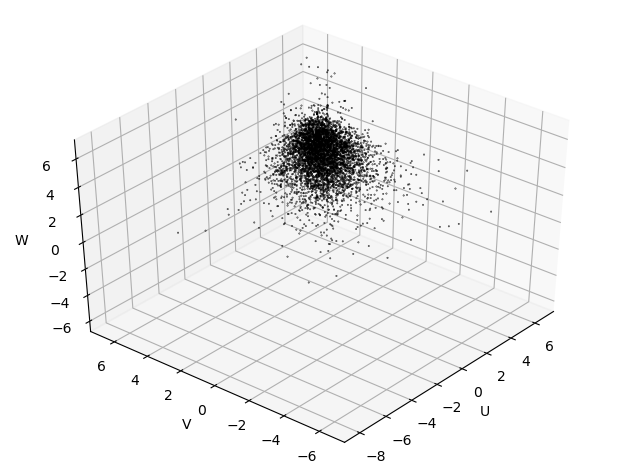

In [9]:
#Plotting new galactocentric coordinates in 3D velocity space.

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("W")

ax.scatter(np.log(ucrd), np.log(vcrd), np.log(wcrd), c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

In [11]:
#An interactive version of the above plot
import ipyvolume as ipv
ipv.quickscatter(np.log(ucoord), np.log(vcoord), np.log(wcoord), size=0.5, color="blue")

In [8]:
#Limiting U and V velocities to match Bovy & Hogg, 2009, then zooming in more
#Also limiting W velocities

uvmask = np.where((ucrd < 60) & (ucrd > -60) & (vcrd < 50) & (vcrd > -60) & (wcrd < 60) & (wcrd > -60))

ushort = ucrd[uvmask]
vshort = vcrd[uvmask]
wshort = wcrd[uvmask]
len(ushort)

33518

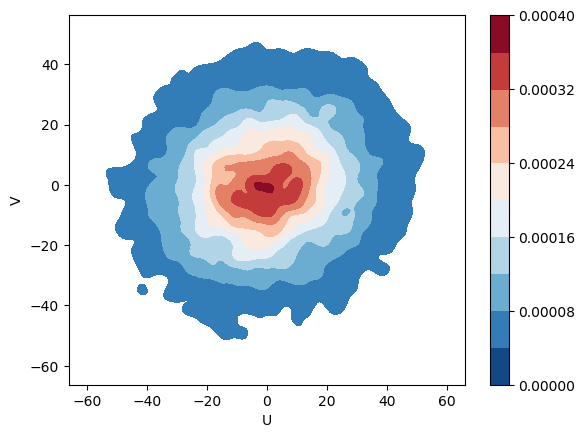

In [30]:
#Kernel density estimate plot of U vs V

sns.kdeplot(ushort, vshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.show()

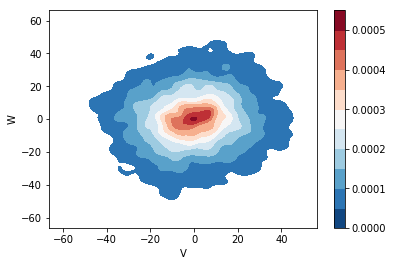

In [15]:
#Kernel density estimate plot of V vs W

sns.kdeplot(vshort, wshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.show()

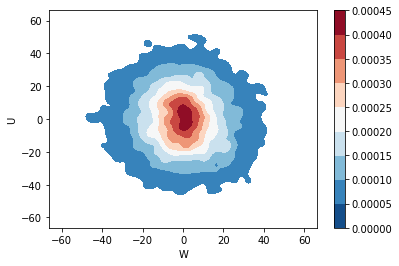

In [16]:
#Kernel density estimate plot of W vs U

sns.kdeplot(wshort, ushort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.show()

In [9]:
from sklearn.cluster import KMeans

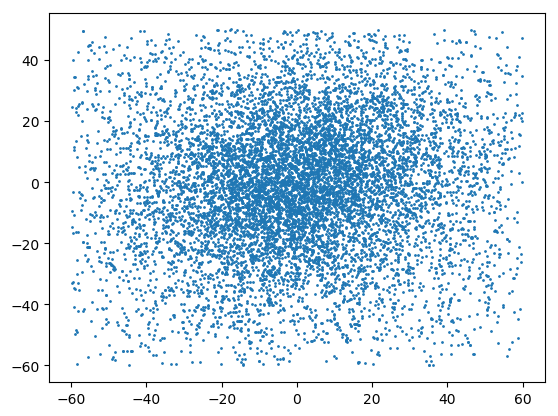

In [30]:
#The beginning of k-means. Clipped dataset from previous plots to be even shorter,
# out of fear of my computer crashing. Plotted simple scatter for comparison.

uveryshort = ushort[1:10000]
vveryshort = vshort[1:10000]

uveryshort = uveryshort.data
vveryshort = vveryshort.data

vsarray = np.vstack((uveryshort, vveryshort)).T
fullarray = np.vstack((ushort.data,vshort.data)).T

plt.scatter(uveryshort, vveryshort, s=1);

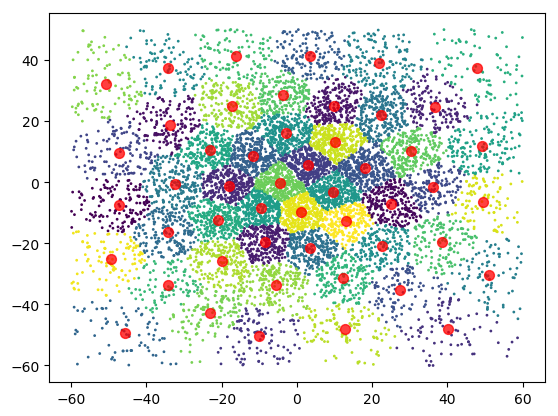

In [29]:
#Initial attempt at applying k-means to the dataset. Not sure if I should 
# be using more or less clusters, or using more or less of the dataset.

kmeans = KMeans(n_clusters=50)
kmeans.fit(vsarray)
y_kmeans = kmeans.predict(vsarray)

plt.scatter(vsarray[:, 0], vsarray[:, 1], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75);